In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from datetime import datetime
from EDMtoolkit import *
from matplotlib.patches import ConnectionPatch
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

In [2]:
filename = "../Datasets/newport/Copepod_Cladoceran_Oikopleura_densities_NH05_1996-present.csv"
data = pd.read_csv(filename, encoding="utf-8")

In [3]:
# data[["GenusSpecies","LifeHistoryStage","TaxaGrouping"]].drop_duplicates().to_csv("Newport_All_Species_Functional_Groups.csv")

In [4]:
# first we construct the t time series since it is identical for all species
dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in data["SampleDate"].unique()]
months = [m.date() for m in pd.date_range("1996-5-1","2022-4-1", freq='MS')]

# Must create a null time series which is 0 during all months
# where there was at least one observation and NULL otherwise
time_series_default = np.array([0 if np.any([date.year == month.year and date.month == month.month for date in dates])
                         else np.nan 
                         for month in months])

n_years = (months[-1] - months[0]).days / 365
t = np.linspace(0,1,num=len(months))

In [5]:
def get_species_series(species_name, life_history_stage):
    
    species_df = data.query('GenusSpecies == ["{}"] and LifeHistoryStage == ["{}"]'.format(species_name, life_history_stage))
    species_dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in species_df["SampleDate"].to_numpy()]
    species_abundances = species_df["Sum(Density (#/m3)"].to_numpy()
    
    ts = time_series_default.copy()
    
    for i in range(ts.shape[0]):
        month = months[i]
        valid_species = np.array([date.year == month.year and date.month == month.month for date in species_dates])
        
        if np.any(valid_species):
            abundance = np.mean(species_abundances[valid_species])
            ts[i] = abundance
        
    return ts

def get_species_aggregate_series(species_name):
    life_stages = pd.unique(data.query('GenusSpecies == ["{}"]'.format(species_name))["LifeHistoryStage"])
    
    time_series = np.zeros(312)
    for life_stage in life_stages:
        time_series += get_species_series(species_name, life_stage)
    
    return time_series

# Determine Most Populous Species

In [6]:
all_genus_species = data["GenusSpecies"].drop_duplicates()
species_dict = dict()
species_agg_dict = dict()

for gs in all_genus_species:
    ts = get_species_aggregate_series(gs)
    total = np.sum(ts, where = ~np.isnan(ts))
    
    species_dict[total] = (gs, ts)
    species_agg_dict[gs] = ts
    
species_time_series_sorted = [species_dict[x] for x in sorted(species_dict, reverse = True)]
species_ordered_by_abundance = [x[0] for x in species_time_series_sorted]

# species_ordered_by_abundance contains the species names in decreasing order of abundance 
# species_agg_dict maps the species name to the time series of every life stage aggregated together

# Ensure Life-Stages are Lag-Uncorrelated
To aggregate several life stages of these species, we first check that one life-stage is not merely a lagged copy of another. For example, the time series of adults may be similar to a lagged version of the child time series because the children become adults. If a correlation like this occurs, then a single time series should be taken as representation of the whole population

KeyboardInterrupt: 

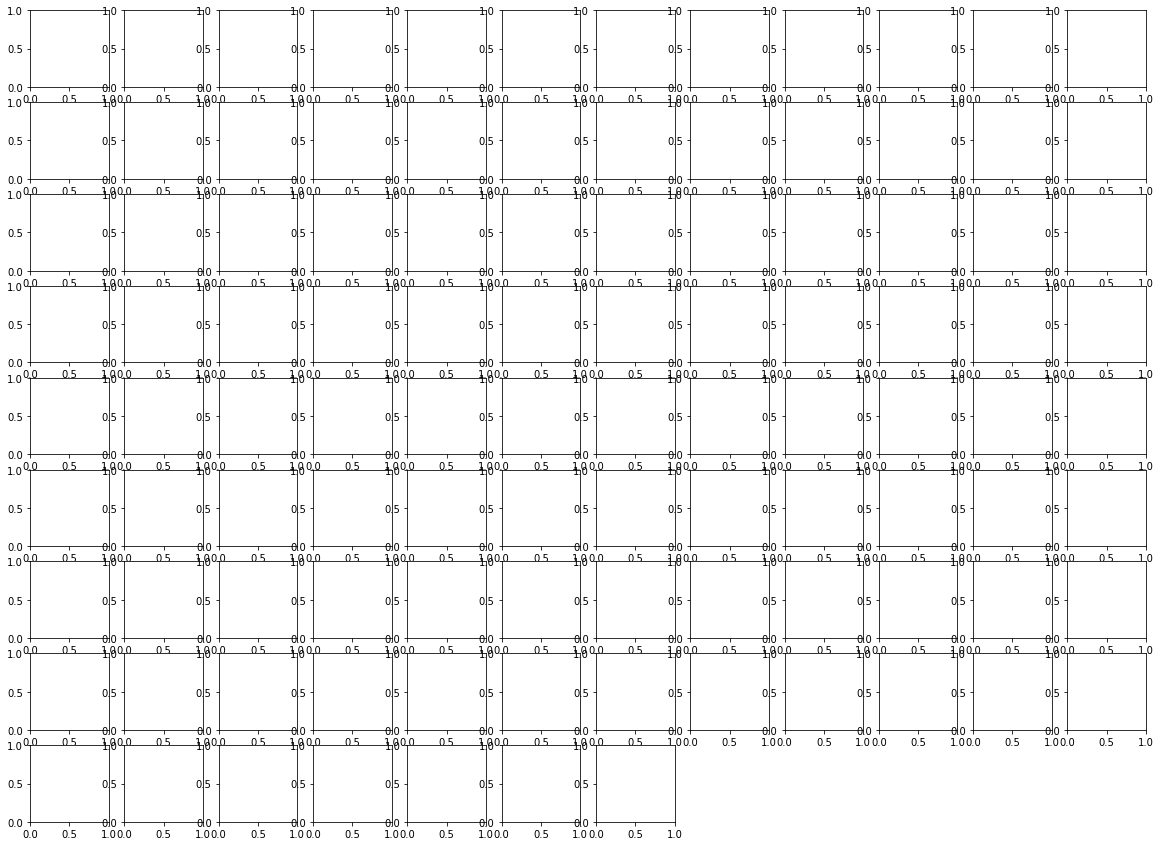

In [7]:
top_4 = species_ordered_by_abundance[:4]
lags = np.arange(7)

for species in top_4:
    life_stages = data.query('GenusSpecies == ["{}"]'.format(species))["LifeHistoryStage"].drop_duplicates().to_numpy()
    fig, ax = plt.subplots(len(life_stages), len(life_stages),figsize=(20,20))
    for i, s1 in enumerate(life_stages):
        for j, s2 in enumerate(life_stages):
            series1 = get_species_series(species, s1)
            series2 = get_species_series(species, s2)
            series1 = series1[~np.isnan(series1)]
            series2 = series2[~np.isnan(series2)]
            
            corr = np.array([np.corrcoef(series1[l:], series2[:-l])[0,1] 
                             if l > 0 else 
                             np.corrcoef(series1, series2)[0,1]
                                 for l in lags])
            
            ax[i,j].plot(lags, corr)
            ax[i,j].set_ylim([0,1])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                ax[i,j].set_ylabel(s1)
            if i == len(life_stages) - 1:
                ax[i,j].set_xlabel(s2)
            
    # fig.set_title(f"Lag vs correlation coefficient for {species}")
    plt.savefig(f"../Figures/newport_lags_of_life_stages/{species}_life_stage_lags.png",dpi=600)

Analysis: In general, it does appear that a lagged version of a young life stage is most correlated with a lagged copy of a later life stage. However, the correlation is at most 0.3, which is not strong enough to disallow aggregation.

# Top 4 Species Results

In [9]:
"""
h = 0
E_max = 6
taus = np.arange(1,7)
r_sqrd_table = np.zeros((len(taus), 4))

for i, species in enumerate(species_ordered_by_abundance[:4]):
    ts = standardize(np.sqrt(get_species_aggregate_series(species)))

    r_sqrds = [get_delta_agg(ts, E_max-1, tau=tau, 
                             horizon = tau - h,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:, i] = r_sqrds
"""

'\nh = 0\nE_max = 6\ntaus = np.arange(1,7)\nr_sqrd_table = np.zeros((len(taus), 4))\n\nfor i, species in enumerate(species_ordered_by_abundance[:4]):\n    ts = standardize(np.sqrt(get_species_aggregate_series(species)))\n\n    r_sqrds = [get_delta_agg(ts, E_max-1, tau=tau, \n                             horizon = tau - h,\n                             return_forecast_skill=True)[2] \n                   for tau in taus]\n    r_sqrd_table[:, i] = r_sqrds\n'

In [8]:
# np.savetxt("newport_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")
r_sqrd_table = np.loadtxt("newport_rsqrd_vs_tau.csv", delimiter=",")

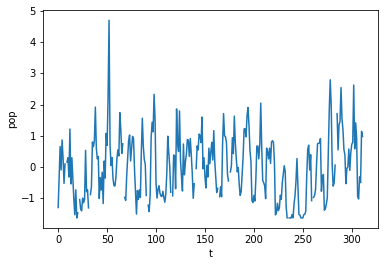

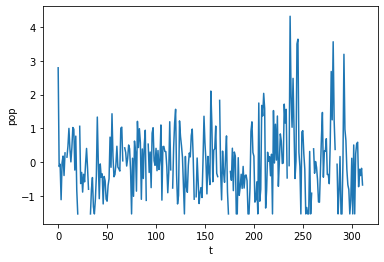

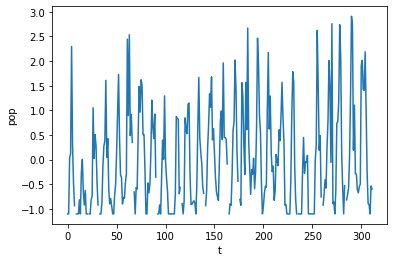

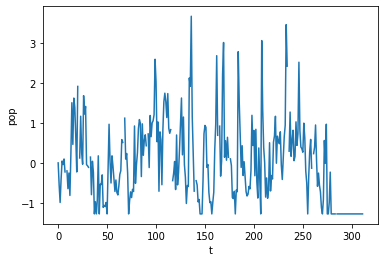

In [10]:
# Check Autocorrelation
taus = np.arange(1,7)
autocorr_table = np.zeros((len(taus), 4))

for i, species_label in enumerate(species_ordered_by_abundance[:4]):
    ts_no_NA = ts[~np.isnan(ts)]
    ts = standardize(np.sqrt(get_species_aggregate_series(species_label)))
    plotTS(ts)
    autocorr_table[:,i] = np.array([np.corrcoef(ts_no_NA[tau:], ts_no_NA[:-tau])[0,1]
                                      for tau in taus])

In [11]:
autocorr_table

array([[ 0.66600034,  0.66600034,  0.31308435,  0.63001518],
       [ 0.42840186,  0.42840186,  0.09572909,  0.3517974 ],
       [ 0.21092232,  0.21092232,  0.05838498,  0.0163752 ],
       [-0.02413978, -0.02413978,  0.04339346, -0.24545602],
       [-0.1240432 , -0.1240432 ,  0.1093293 , -0.40023522],
       [-0.11689827, -0.11689827,  0.05190115, -0.41416659]])

In [12]:
species_ordered_by_abundance[:4]

['PSEUDOCALANUS', 'OIKOPLEURA', 'ACARTIA LONGIREMIS', 'PARACALANUS PARVUS']

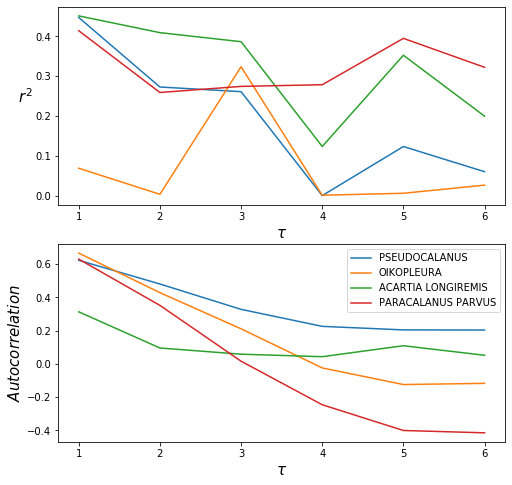

In [103]:
# r_sqrd_table = np.loadtxt("newport_rsqrd_vs_tau.csv", delimiter=",")

fig, ax = plt.subplots(2, figsize=(8,8))
for i, species_label in enumerate(species_ordered_by_abundance[:4]):
    ax[0].plot(taus, r_sqrd_table[:,i], label=species_label)
    
for i, species_label in enumerate(species_ordered_by_abundance[:4]):
    ax[1].plot(taus, autocorr_table[:,i], label=species_label)
    
# ax[1].set_ylabel(r"$Auto correlation$")
# ax[1].set_xlabel(r"$Lag$")

# ax[0].set_ylabel(r"$r^2$")
# ax[0].set_xlabel(r"$\tau$")

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend()
# plt.savefig("../Figures/Empirical_embedding_parameter_choice/NewportEmbeddingParameters.png", dpi = 300)
plt.savefig(f"../PDF_figures_tables/newport_multiwindow/NewportEmbeddingParameters.pdf", format="pdf", bbox_inches="tight")

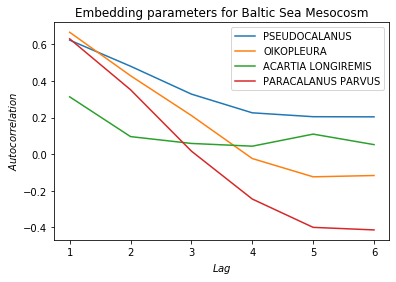

Final choice is tau = 3 across all series as autocorrelations diminishes for all series while retaining solid forecast skill across the board. Note that the strongly negative autocorrelation for Paracalanus Parvus at high lags is as bad as positive autocorrelation.

In [25]:
delta_agg, theta_agg, r_sqrd = get_delta_agg(ts, 3, tau=4, horizon=1, return_forecast_skill=True)
print(f"delta = {delta_agg:.3}, theta = {theta_agg:.3}, r2 = {r_sqrd:.3}, stationary window = {n_years / np.sqrt(delta_agg):.3}")

delta = 0.0, theta = 0.111, r2 = 0.459, stationary window = inf


c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


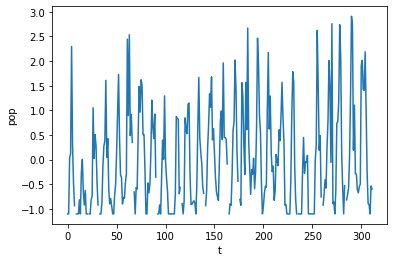

0.9999999999999998
0.6236269970133446
0.35537667002985857
0.03573109682112542
-0.2101298076704495


4

In [30]:
# 'ACARTIA LONGIREMIS'

ts = standardize(np.sqrt(get_species_aggregate_series('ACARTIA LONGIREMIS')))
plotTS(ts)
find_tau_autocorr(ts)

In [31]:
delta_agg, theta_agg, r_sqrd = get_delta_agg(ts, 3, tau=4, horizon=1, return_forecast_skill=True)
print(f"delta = {delta_agg:.3}, theta = {theta_agg:.3}, r2 = {r_sqrd:.3}, stationary window = {n_years / np.sqrt(delta_agg):.3}")

delta = 0.0, theta = 0.936, r2 = 0.432, stationary window = inf


c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


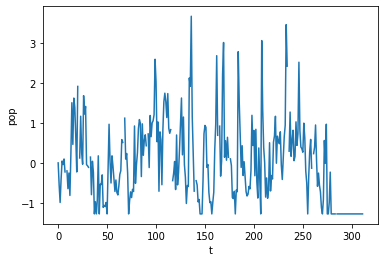

0.9999999999999998
0.6286398393049017
0.47392642575508037
0.34319182438859386
0.24123757493572745
0.1805760416303382
0.23491429535430317
0.18486826528215144
0.21765685201410462
0.20293308770734733
0.2750923653299283
0.2843101209112911
0.3072557188426454
0.3087620260647254
0.2605744307717656
0.24491951699131875
0.21499348548342753
0.12324383499593544
0.06970423160811853
-0.0005768057902795043


19

In [32]:
# PARACALANUS PARVUS

ts = standardize(np.sqrt(get_species_aggregate_series('PARACALANUS PARVUS')))
plotTS(ts)
find_tau_autocorr(ts)

In [33]:
delta_agg, theta_agg, r_sqrd = get_delta_agg(ts, 3, tau=4, horizon=1, return_forecast_skill=True)
print(f"delta = {delta_agg:.3}, theta = {theta_agg:.3}, r2 = {r_sqrd:.3}, stationary window = {n_years / np.sqrt(delta_agg):.3}")

delta = 0.56, theta = 0.22, r2 = 0.409, stationary window = 34.6


# Effect of Time Window on Pseudocalanus
The point of this experiment is to determine the impact of time series window on our assessment of nonstationarity. We conjecture that at intermediate time series lengths we will get the most nonstationarity positives. To test this, we assess nonstationarity for all subsequences of the original time series with length a multiple of 12, and starting index is a multiple of 12.

In [50]:
def idenfityNonstationarity(length):
    smoothed = np.zeros(26)
    whatToDivideBy = np.zeros(26)
    deltas = results[results[:,0] == length,2]
    unitLen=int(length/12)
    
    for i, delta in enumerate(deltas):
        smoothed[i:i+unitLen] += np.ones(unitLen) * delta
        whatToDivideBy[i:i+unitLen] += np.ones(unitLen)
        
    return smoothed / whatToDivideBy

def drawBracket(start_year, length, ax):
    start_index = start_year - 1996
    length_index = 26 - length
    ax.plot(np.array([start_index, start_index + length ]),
            np.ones(2)*length_index, c="black")

In [51]:
species_ordered_by_abundance[:4]

['PSEUDOCALANUS', 'OIKOPLEURA', 'ACARTIA LONGIREMIS', 'PARACALANUS PARVUS']

In [52]:
for index in range(4):
    species = species_ordered_by_abundance[:4][index]
    species_label = ['Pseudocalanus', 'Oikopleura', 'Acartia Longiremis', 'Paracalanus Parvus']

    results = np.loadtxt(f"{species}_time_window.csv", delimiter=",")
    
    print(f"{species} r^2 = {results[-1,4]}")

PSEUDOCALANUS r^2 = 0.50375
OIKOPLEURA r^2 = 0.06682
ACARTIA LONGIREMIS r^2 = 0.55637
PARACALANUS PARVUS r^2 = 0.39792


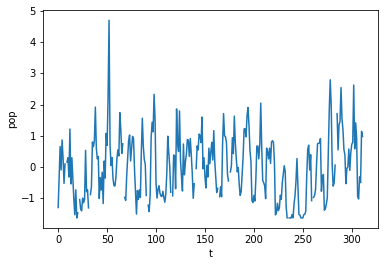

In [94]:
#### Pseudocalanus

index = 0
species = species_ordered_by_abundance[:4][index]
species_label = [r'Pseudocalanus', r'Oikopleura', r'Acartia $longiremis$', r'Paracalanus $parvus$']

ts = standardize(np.sqrt(get_species_aggregate_series(species)))
plotTS(ts)

In [91]:
maxLen = ts.shape[0]
lengths = np.arange(24,maxLen+1,step=12)

"""
E_max = 6
tau = 1
h = 0

n_rows = 325
# length, starting index, delta, theta, r_sqrd
results = np.zeros((n_rows, 5))
tally = 0

for length in lengths:
    for start in np.arange(0, maxLen - length+1, step=12):
        ts_chunk = ts[start:length+start]
        delta, theta, r_sqrd = get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)
        results[tally] = np.array([length, start, delta, theta, r_sqrd])
        tally += 1
"""

'\nE_max = 6\ntau = 1\nh = 0\n\nn_rows = 325\n# length, starting index, delta, theta, r_sqrd\nresults = np.zeros((n_rows, 5))\ntally = 0\n\nfor length in lengths:\n    for start in np.arange(0, maxLen - length+1, step=12):\n        ts_chunk = ts[start:length+start]\n        delta, theta, r_sqrd = get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)\n        results[tally] = np.array([length, start, delta, theta, r_sqrd])\n        tally += 1\n'

In [92]:
# np.savetxt("pseudocalanus_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")
# results = np.loadtxt("PARACALANUS PARVUS_time_window.csv", delimiter=",")
results = np.loadtxt(f"{species}_time_window.csv", delimiter=",")

In [93]:
print(f"r^2 for whole series = {results[-1,4]}")
print(f"delta for whole series = {results[-1,2]}")

r^2 for whole series = 0.39792
delta for whole series = 2.30989


Text(0, 0.5, '$r^2$')

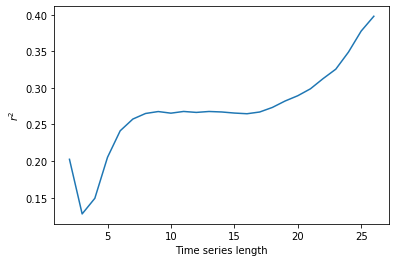

In [86]:
plt.plot(lengths / 12, [np.mean(results[results[:,0] == length,4]) for length in lengths])
plt.xlabel("Time series length")
plt.ylabel(r"$r^2$")

In [87]:
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba]) 

In [88]:
# offset,
nonstationarityHeatMap = np.zeros((25,25)) * np.nan
for l, o, d, t, r in results:
    i_length = 24-(int(l/12) - 2)
    i_offset = int(o/12)
    nonstationarityHeatMap[i_length, i_offset] = d

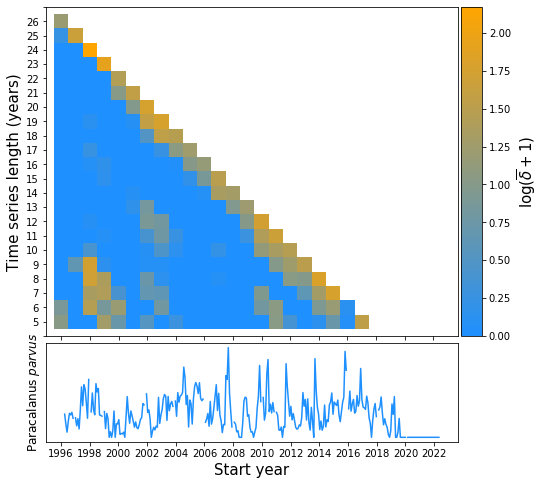

In [89]:
fig, ax = plt.subplots(1,figsize=(8,8))
# im = ax.imshow(nonstationarityHeatMap[3:,:-3])
im = ax.imshow(np.log(nonstationarityHeatMap[:-3]+1), cmap=custom_cmap)
# ax.set_xlabel("Start year",fontsize=15)
# ax.set_xticks(np.arange(29,step=2))
#ax.set_xticks([])
ax.set_xticks(np.arange(0,26+1,step=2))
ax.set_xlim(-1.08,27.7)
# ax.set_xticklabels(np.arange(1996,2023,step=2))

ax.set_ylabel("Time series length (years)",fontsize=15)
# ax.set_yticks(np.arange(21+1))
# ax.set_yticklabels(np.arange(21+1)+5)
# ax.set_ylim(2,25)
ax.set_yticks(np.arange(-1,22+1))
ax.set_yticklabels(np.flip(np.hstack([np.arange(4,25+1)+1,""])))

# drawBracket(2008, 9, ax)
# drawBracket(2014, 8, ax)
# drawBracket(1996, 26, ax)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

axTS = divider.append_axes('bottom', size='30%', pad=0.1)

axTS.plot(np.linspace(1996.264,2022.335,num=312), ts,c="dodgerblue")
axTS.set_xticks(np.arange(1996,2022+1,step=2))
axTS.set_yticks([])
axTS.set_ylabel(species_label[index], fontsize= 12)
axTS.set_xlabel("Start year",fontsize=15)

# con = ConnectionPatch(xyA=(20,18), xyB=(2018,1), coordsA="data",
#                     coordsB="data", axesA=ax, axesB=axTS)
# ax.add_artist(con)

# plt.savefig(f"../Figures/newport_multiwindow_analysis/{species}_multiwindow.png", dpi=300)
plt.savefig(f"../PDF_figures_tables/newport_multiwindow/{species}_multiwindow.pdf", format="pdf", bbox_inches="tight")

# Time Window on Most Abundant Species

In [200]:
for length in lengths:
    for start in np.arange(0, maxLen - length+1, step=12):
        print(length, start)

24 0
24 12
24 24
24 36
24 48
24 60
24 72
24 84
24 96
24 108
24 120
24 132
24 144
24 156
24 168
24 180
24 192
24 204
24 216
24 228
24 240
24 252
24 264
24 276
24 288
36 0
36 12
36 24
36 36
36 48
36 60
36 72
36 84
36 96
36 108
36 120
36 132
36 144
36 156
36 168
36 180
36 192
36 204
36 216
36 228
36 240
36 252
36 264
36 276
48 0
48 12
48 24
48 36
48 48
48 60
48 72
48 84
48 96
48 108
48 120
48 132
48 144
48 156
48 168
48 180
48 192
48 204
48 216
48 228
48 240
48 252
48 264
60 0
60 12
60 24
60 36
60 48
60 60
60 72
60 84
60 96
60 108
60 120
60 132
60 144
60 156
60 168
60 180
60 192
60 204
60 216
60 228
60 240
60 252
72 0
72 12
72 24
72 36
72 48
72 60
72 72
72 84
72 96
72 108
72 120
72 132
72 144
72 156
72 168
72 180
72 192
72 204
72 216
72 228
72 240
84 0
84 12
84 24
84 36
84 48
84 60
84 72
84 84
84 96
84 108
84 120
84 132
84 144
84 156
84 168
84 180
84 192
84 204
84 216
84 228
96 0
96 12
96 24
96 36
96 48
96 60
96 72
96 84
96 96
96 108
96 120
96 132
96 144
96 156
96 168
96 180
96 192
96 204

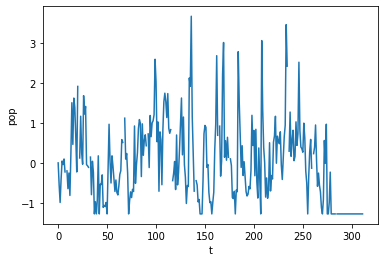

24 0
24 12
24 24
24 36
24 48
24 60
24 72
24 84
24 96
24 108
24 120
24 132
24 144
24 156
24 168
24 180
24 192
24 204
24 216
24 228
24 240
24 252
24 264
24 276
24 288
36 0
36 12
36 24
36 36
36 48
36 60
36 72
36 84
36 96
36 108
36 120
36 132
36 144
36 156
36 168
36 180
36 192
36 204
36 216
36 228
36 240
36 252
36 264
36 276
48 0
48 12
48 24
48 36
48 48
48 60
48 72
48 84
48 96
48 108
48 120
48 132
48 144
48 156
48 168
48 180
48 192
48 204
48 216
48 228
48 240
48 252
48 264
60 0
60 12
60 24
60 36
60 48
60 60
60 72
60 84
60 96
60 108
60 120
60 132
60 144
60 156
60 168
60 180
60 192
60 204
60 216
60 228
60 240
60 252
72 0
72 12
72 24
72 36
72 48
72 60
72 72
72 84
72 96
72 108
72 120
72 132
72 144
72 156
72 168
72 180
72 192
72 204
72 216
72 228
72 240
84 0
84 12
84 24
84 36
84 48
84 60
84 72
84 84
84 96
84 108
84 120
84 132
84 144
84 156
84 168
84 180
84 192
84 204
84 216
84 228
96 0
96 12
96 24
96 36
96 48
96 60
96 72
96 84
96 96
96 108
96 120
96 132
96 144
96 156
96 168
96 180
96 192
96 204

In [203]:
# for i, species_label in enumerate(species_ordered_by_abundance[:4]):
species_label = species_ordered_by_abundance[3]

ts = standardize(np.sqrt(species_agg_dict[species_label]))
plotTS(ts)

maxLen = ts.shape[0]
lengths = np.arange(24,maxLen+1,step=12)

E_max = 4
tau = 3
h = 0

n_rows = 325
# length, starting index, delta, theta, r_sqrd
# results = np.zeros((n_rows, 5))
tally = 0

for length in lengths:
    for start in np.arange(0, maxLen - length+1, step=12):
        print(length, start)
        if results[tally, 0] != 0:
            tally += 1
            continue

        ts_chunk = ts[start:length+start]
        try:
            delta, theta, r_sqrd = get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)
        except:
            delta, theta, r_sqrd = (0,0,0)
        results[tally] = np.array([length, start, delta, theta, r_sqrd])
        tally += 1

np.savetxt(f"{species_label}_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")

In [195]:
results.shape

(325, 5)

In [204]:
results

array([[2.40000000e+01, 0.00000000e+00, 2.37265214e+00, 0.00000000e+00,
        3.78332053e-02],
       [2.40000000e+01, 1.20000000e+01, 9.15497906e-01, 0.00000000e+00,
        1.74922101e-01],
       [2.40000000e+01, 2.40000000e+01, 0.00000000e+00, 1.87500000e-01,
        9.50622828e-02],
       ...,
       [3.00000000e+02, 0.00000000e+00, 2.73559391e-01, 4.61575039e-02,
        3.43118790e-01],
       [3.00000000e+02, 1.20000000e+01, 4.28845909e+00, 5.52820717e-02,
        4.12108470e-01],
       [3.12000000e+02, 0.00000000e+00, 2.30988658e+00, 8.48318020e-02,
        3.97916466e-01]])

# All Time Series Results

5


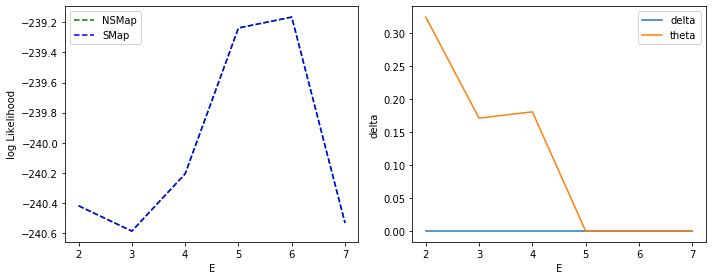

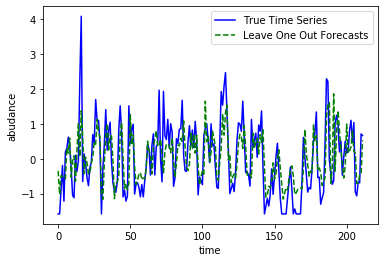

PSEUDOCALANUS 5, CV, delta = 0.000, theta = 0.113 r^2 = 0.424
5


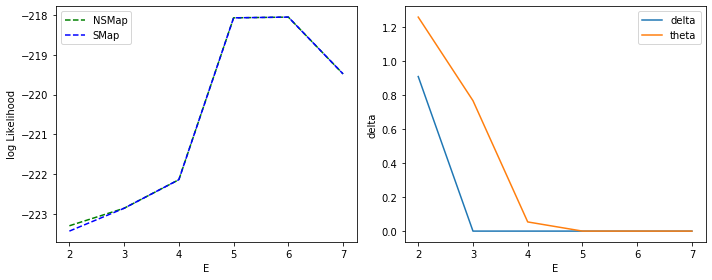

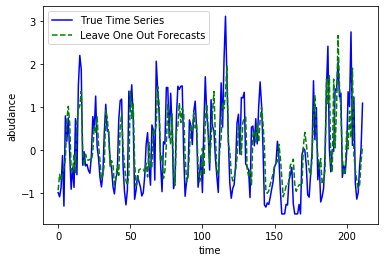

PSEUDOCALANUS Female, Adult, delta = 0.169, theta = 0.368 r^2 = 0.508
14


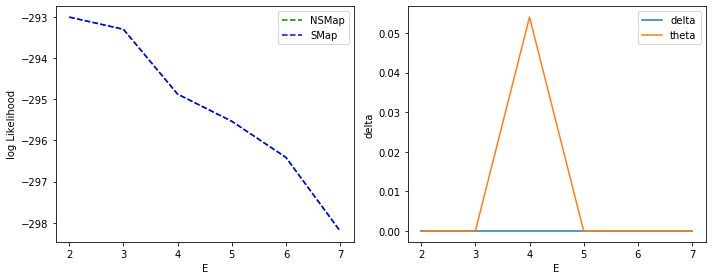

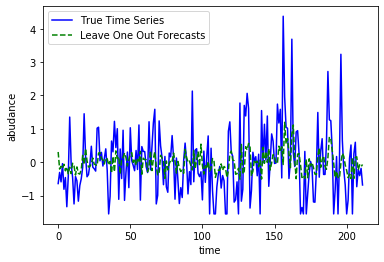

OIKOPLEURA Unknown, delta = 0.000, theta = 0.009 r^2 = 0.073
5


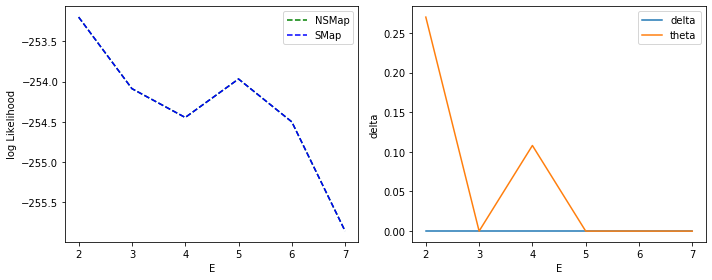

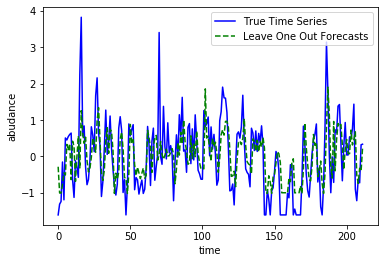

PSEUDOCALANUS 4, CIV, delta = 0.000, theta = 0.063 r^2 = 0.351
4


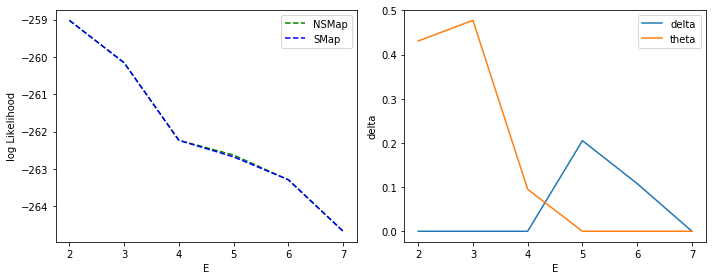

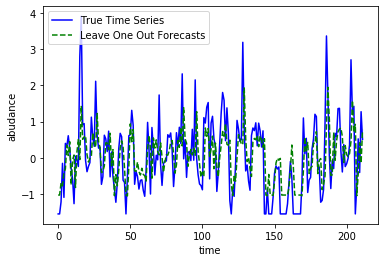

PSEUDOCALANUS 3, CIII, delta = 0.053, theta = 0.166 r^2 = 0.355
5


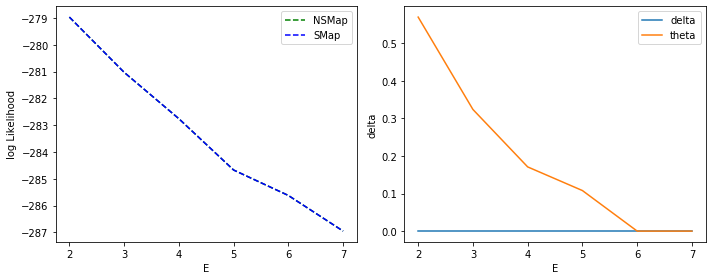

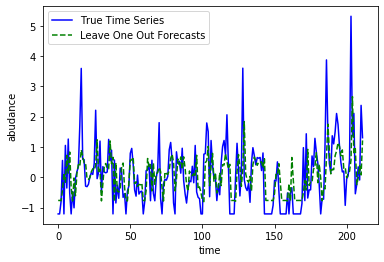

PSEUDOCALANUS 2, CII, delta = 0.000, theta = 0.196 r^2 = 0.255
18


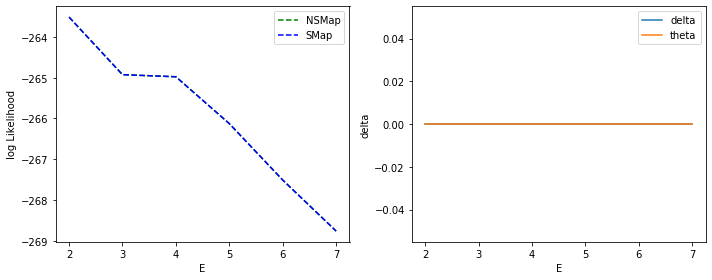

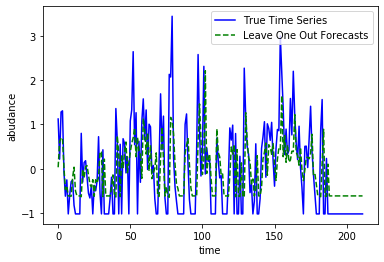

PARACALANUS PARVUS Copepodite, delta = 0.000, theta = 0.000 r^2 = 0.297
4


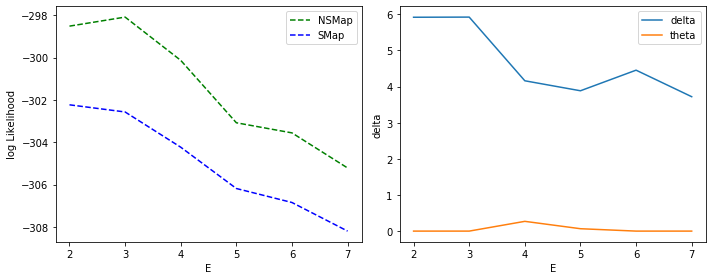

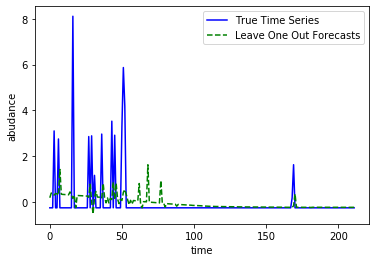

PSEUDOCALANUS Copepodite, delta = 5.015, theta = 0.069 r^2 = 0.038
4


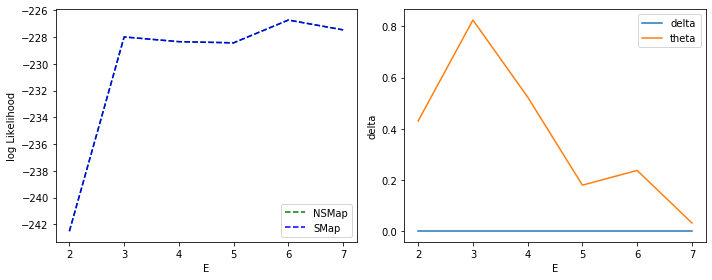

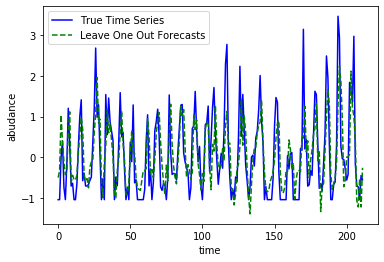

ACARTIA LONGIREMIS Female, Adult, delta = 0.000, theta = 0.372 r^2 = 0.513
4


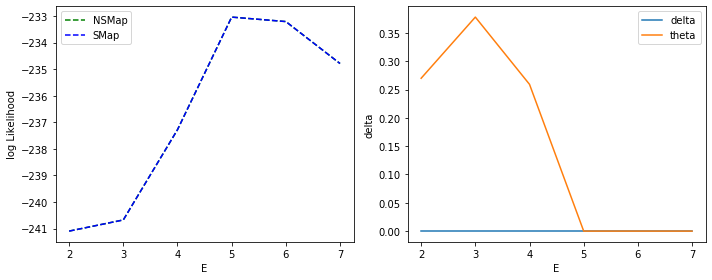

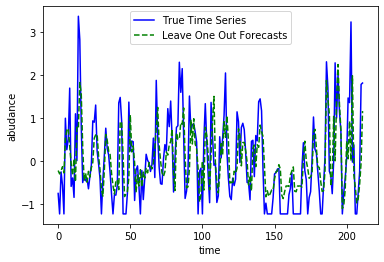

PSEUDOCALANUS Male, Adult, delta = 0.000, theta = 0.151 r^2 = 0.420


In [37]:
newport_species_fg = np.array(["1","1"])
newport_w_s_r2 = np.zeros(3)

for species_name, fg, _ in top_species[:10]:
    X = get_species_series(species_name, fg)
    Xr = standardize(np.sqrt(X[:,None]))
    
    # plotTS(Xr, title=species_name + " " + fg)
    # print(find_tau_autocorr(Xr))
    
    try: 
        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, 5, t=t,tau=4, return_forecast_skill=True)
    except:
        print("Too many 0s to do linear algebra")
        continue

    newport_species_fg = np.vstack([newport_species_fg, np.array([species_name, fg])])
    newport_w_s_r2 = np.vstack([newport_w_s_r2, np.array([delta_agg, theta_agg, r_sqrd])])

    print(f"{species_name} {fg}, delta = {delta_agg:.3f}, theta = {theta_agg:.3f} r^2 = {r_sqrd:.3f}")

In [25]:
# np.savetxt("newport_sp`ecies_fg.txt", newport_species_fg, fmt=["%s;","%s"])
# np.savetxt("newport_w_s_r2.txt", newport_w_s_r2, delimiter=",")

In [26]:
newport_w_s_r2 = np.loadtxt("newport_w_s_r2.txt", delimiter=",")
newport_species_fg = np.loadtxt("newport_species_fg.txt", delimiter=";", dtype=str)

In [29]:
for species, genus, w_s, r_sqrd in np.hstack([newport_species_fg, newport_w_s_r2]):
    print(f"{species} {genus}, w_s = {float(w_s):.3f}, r^2 = {float(r_sqrd):.3f}")

ACARTIA LONGIREMIS  Copepodite, w_s = inf, r^2 = 0.042
ACARTIA LONGIREMIS  Female, Adult, w_s = 18.084, r^2 = 0.209
ACARTIA LONGIREMIS  Male, Adult, w_s = 121.609, r^2 = 0.237
ACARTIA TONSA  Copepodite, w_s = 11.694, r^2 = 0.091
ACARTIA TONSA  Female, Adult, w_s = 65.672, r^2 = 0.014
ACARTIA TONSA  Male, Adult, w_s = inf, r^2 = 0.000
CALANUS MARSHALLAE  1, CI, w_s = inf, r^2 = 0.007
CALANUS MARSHALLAE  2, CII, w_s = 203.735, r^2 = 0.013
CALANUS MARSHALLAE  3, CIII, w_s = inf, r^2 = 0.014
CALANUS MARSHALLAE  4, CIV, w_s = inf, r^2 = 0.005
CALANUS MARSHALLAE  5, CV, w_s = inf, r^2 = 0.037
CALANUS MARSHALLAE  Female, Adult, w_s = 22.628, r^2 = 0.048
CALANUS PACIFICUS  1, CI, w_s = inf, r^2 = 0.153
CALANUS PACIFICUS  2, CII, w_s = 40.468, r^2 = 0.000
CALANUS PACIFICUS  3, CIII, w_s = inf, r^2 = 0.286
CALANUS PACIFICUS  4, CIV, w_s = 35.670, r^2 = 0.012
CALANUS PACIFICUS  5, CV, w_s = 139.259, r^2 = 0.004
CALANUS PACIFICUS  Female, Adult, w_s = 17.705, r^2 = 0.131
CALOCALANUS  Female, Adult